# Working on...

#### First method is _filter()

In [3]:
import os
import wave
# This is origin code
"""
def _filter(self):
        audiopaths_and_text_new = []
        lengths = []
        for audiopath, text in self.audiopaths_and_text:
            # we filter the text with appropriate length
            if self.min_text_len <= len(text) and len(text) <= self.max_text_len:
                audiopaths_and_text_new.append([audiopath, text])
                # lengths store the length of spectrogram
                # length of spectrogram is length of audio // hop_length
                lengths.append(os.path.getsize(audiopath) // (2 * self.hop_length))
        self.audiopaths_and_text = audiopaths_and_text_new
        self.lengths = lengths
"""
# after processed by load_filepaths_and_text in data_utils and utils
# the audiopaths_and_text will be like this.

lengths = []
hop_length = 256
min_text_len = 1
max_text_len = 190 # the same as original vits code.
audiopaths_and_text = [('audio/LJ001-0001.wav','Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition')]
def _filter():
        global audiopaths_and_text, lengths
        audiopaths_and_text_new = []
        local_length = []
        for audiopath, text in audiopaths_and_text:
            # we filter the text with appropriate length
            if min_text_len <= len(text) and len(text) <= max_text_len:
                audiopaths_and_text_new.append([audiopath, text])
                # lengths store the length of spectrogram
                # length of spectrogram is length of audio // hop_length
                local_length.append(os.path.getsize(audiopath) // (2 * hop_length))
        audiopaths_and_text = audiopaths_and_text_new
        lengths = local_length
_filter()
print(lengths)

[831]


In [25]:
wavFile = r"audio/LJ001-0001.wav"
f = wave.open(wavFile)
# get params of the file
params = f.getparams()
Channels = f.getnchannels()
SampleRate = f.getframerate()
bit_type = f.getsampwidth() * 8
frames = f.getnframes()
# Duration = samplingpoints / samplingrates
Duration = wav_time = frames / float(SampleRate)  # 单位为s
print("(Channels)：", Channels)
print("(SampleRate)：", SampleRate)
print("(Precision)：", bit_type)
print("(frames)：", frames)
print("(Duration)：", Duration)
print("(bits rate): ", SampleRate*bit_type)
print("(File Size): ", frames*2)
print("(Spectrogram Length): ", frames*2 // (2 * hop_length))

(Channels)： 1
(SampleRate)： 22050
(Precision)： 16
(frames)： 212893
(Duration)： 9.65501133786848
(bits rate):  352800
(File Size):  425786
(Spectrogram Length):  831


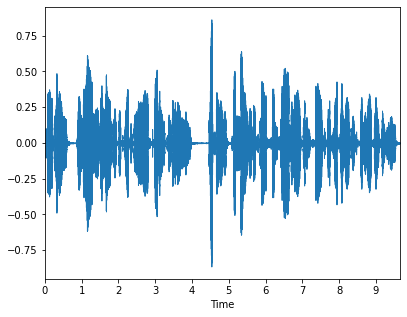

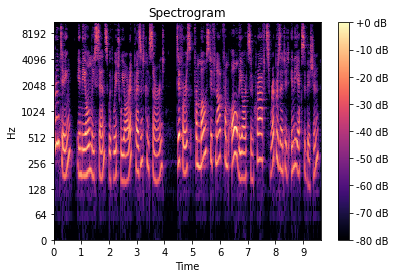

In [27]:
# Draw WaveForm
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
plt.figure(figsize=(14, 5))
y, sr = librosa.load(wavFile)
# Draw the waveform
plt.subplot(1, 2, 1)
librosa.display.waveplot(y, sr=sr)
D = librosa.stft(y, hop_length=hop_length)

# Convert the STFT to a magnitude spectrogram
spectrogram = np.abs(D)

# Display the spectrogram
plt.figure()
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                         sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

## Explanation
The length of a waveform is the number of frames, and the file size is the number of frames multiplied by 2 (each frame requires 2 bytes for storage). Furthermore, converting a waveform to a spectrum requires many small segments of the waveform (the meaning of hop_length is to convert a certain length of waveform into one unit of spectrum). Since the file size is the number of frames divided by 2, we can divide the file size by hop_length * 2, which becomes the number of frames divided by hopsize, and the final result is the length of the spectrum.